# install library

In [ ]:
import os

if os.environ.get("KAGGLE_KERNEL_RUN_TYPE") is None:
    ON_KAGGLE = False
else:
    ON_KAGGLE = True
if not ON_KAGGLE:
    import shutil
    from requests import get

    from google.colab import drive, files
    # mount Google Drive
    drive.mount("/content/drive")
else:
    for dirname, _, filenames in os.walk('/kaggle/input'):
        for filename in filenames:
            print(os.path.join(dirname, filename))

Mounted at /content/drive


In [ ]:
if not ON_KAGGLE: 
    !pip uninstall -y kaggle
    !pip install kaggle
    !mkdir /root/.kaggle
    !cp /content/drive/MyDrive/kaggla-za/kaggle.json /root/.kaggle
    !kaggle datasets download -d  kozodoi/timm-pytorch-image-models
    !mkdir -p ../input/timm-pytorch-image-models
    !unzip -n -qq timm-pytorch-image-models.zip -d ../input/timm-pytorch-image-models

    #一回のみ
    # !kaggle datasets download -d kalfirst/animal-imbalance-classification-round2
    # !mkdir -p ../content/drive/MyDrive/kaggla-za/E002Round3/Week2/AnimalImbalance/data/animal-imbalance-classification-round2
    # !unzip -n -qq animal-imbalance-classification-round2.zip -d ../content/drive/MyDrive/kaggla-za/E002Round3/Week2/AnimalImbalance/data/animal-imbalance-classification-round2

    !kaggle datasets download -d kalfirst/animal-imbalance-classification-round2
    !mkdir -p ../input/animal-imbalance-classification-round2
    !unzip -n -qq animal-imbalance-classification-round2.zip -d ../input/animal-imbalance-classification-round2


Found existing installation: kaggle 1.5.12
Uninstalling kaggle-1.5.12:
  Successfully uninstalled kaggle-1.5.12
     |████████████████████████████████| 58 kB 4.4 MB/s 
  Created wheel for kaggle: filename=kaggle-1.5.12-py3-none-any.whl size=73051 sha256=2cb7f8e19bf9ec258c2ffd0be473a605d4ec5332de538563abc5ae33943337da
  Stored in directory: /root/.cache/pip/wheels/62/d6/58/5853130f941e75b2177d281eb7e44b4a98ed46dd155f556dc5
Successfully built kaggle
 84% 12.0M/14.3M [00:00<00:00, 124MB/s]
100% 14.3M/14.3M [00:00<00:00, 135MB/s]
 90% 105M/117M [00:01<00:00, 74.4MB/s] 
100% 117M/117M [00:01<00:00, 72.5MB/s]


In [ ]:
import sys
sys.path.append("../input/timm-pytorch-image-models/pytorch-image-models-master")

if not ON_KAGGLE:
    !pip install albumentations==0.4.6
import albumentations as A
from albumentations.pytorch import ToTensorV2

import gc
import math
import os
import pickle
import random
import re
import time
import warnings
from contextlib import contextmanager

from pathlib import Path
from PIL import Image

#import albumentations as A
import cv2
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy as sp
import torch
import torch.nn as nn
import torch.nn.functional as F


#from albumentations.pytorch import ToTensorV2
from scipy.special import softmax
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from torch.optim import SGD, Adam, AdamW, RAdam
from torch.optim.lr_scheduler import CosineAnnealingLR, CosineAnnealingWarmRestarts, ReduceLROnPlateau
from torch.utils.data import DataLoader, Dataset
from tqdm.auto import tqdm

import timm
warnings.filterwarnings('ignore')

     |████████████████████████████████| 117 kB 8.2 MB/s 
     |████████████████████████████████| 948 kB 59.8 MB/s 
  Created wheel for albumentations: filename=albumentations-0.4.6-py3-none-any.whl size=65174 sha256=a8f8295ccc5a8963831a75b5d757a085fdb4df871084a9afa81b629d4defb582
  Stored in directory: /root/.cache/pip/wheels/cf/34/0f/cb2a5f93561a181a4bcc84847ad6aaceea8b5a3127469616cc
Successfully built albumentations
  Attempting uninstall: imgaug
    Found existing installation: imgaug 0.2.9
    Uninstalling imgaug-0.2.9:
      Successfully uninstalled imgaug-0.2.9
  Attempting uninstall: albumentations
    Found existing installation: albumentations 0.1.12
    Uninstalling albumentations-0.1.12:
      Successfully uninstalled albumentations-0.1.12


# Config


In [ ]:
class Config:
    Version = "exp24" # model save時のversion
    #MODEL_NAME = "resnet34" # モデル名
    #MODEL_NAME = "efficientnet_b0" # モデル名
    #MODEL_NAME = "efficientnet_b1" # モデル名
    #MODEL_NAME = "efficientnet_b2" # モデル名
    #MODEL_NAME = "efficientnet_b3" # モデル名
    #MODEL_NAME = "efficientnet_b4" # モデル名
    #MODEL_NAME = "efficientnet_b5" # モデル名
    #MODEL_NAME = "efficientnet_b6" # モデル名
    #MODEL_NAME = "efficientnet_b7" # モデル名
    #MODEL_NAME = "tf_efficientnet_b0_ns" # モデル名
    MODEL_NAME = "tf_efficientnet_b1_ns" # モデル名
    #MODEL_NAME = "tf_efficientnet_b2_ns" # モデル名
    #MODEL_NAME = "resnet50" # モデル名
    #MODEL_NAME = "swin_large_patch4_window7_224"
    #MODEL_NAME = "swin_base_patch4_window7_224"
    #MODEL_NAME = "swin_small_patch4_window7_224"
    #MODEL_NAME = "swin_large_patch4_window12_384"
    #MODEL_NAME = "swin_base_patch4_window12_384"


    if ON_KAGGLE:
        # if MODEL_NAME == 'resnet34':
        #     model_name = '../input/pt-longformer-base' # https://www.kaggle.com/kishalmandal/pt-longformer-base
        # elif MODEL_NAME == 'roberta-base':
        #     model_name = '../input/roberta-base' #https://www.kaggle.com/abhishek/roberta-base
        # elif modeMODEL_NAMEl_savename == 'roberta-large':
        #     model_name = '../input/robertalarge' # https://www.kaggle.com/marshal02/robertalarge
        # elif MODEL_NAME == 'longformer-large':
        #     model_name = '../input/longformerlarge4096' # https://www.kaggle.com/hengzheng/longformerlarge4096 
        #base_dir = '/content/drive/MyDrive/petfinder'
        #data_dir = '../input/digit-recognizer/' # = DATA_PATH
        data_dir = '../input/animal-imbalance-classification-round2' # = DATA_PATH
        pre_data_dir = './preprocessed/'
        model_dir = '.'
        output_dir = '.'   
    else:
        # customize for my own Google Colab Environment
        # if model_savename == 'longformer':
        #     model_name = 'allenai/longformer-base-4096'
        # elif model_savename == 'roberta-base':
        #     model_name = 'roberta-base'
        base_dir = '/content/drive/MyDrive/kaggla-za/E002Round3/Week2/AnimalImbalance'
        data_dir = '../input/animal-imbalance-classification-round2' #os.path.join(base_dir, '../input/animal-imbalance-classification-round2')
        #pre_data_dir = os.path.join(base_dir, 'data/preprocessed')
        model_dir = os.path.join(base_dir, f'model/{Version}')
        output_dir = os.path.join(base_dir, f'output/{Version}')    

    is_debug = False
    if MODEL_NAME == 'resnet34':
        size = 224 # リサイズした後の画像のサイズ
        model_lr = 1e-5
    elif MODEL_NAME == 'roberta-base':
        size = 224 # リサイズした後の画像のサイズ
        model_lr = 1e-5
    elif MODEL_NAME == 'resnet50':
        size = 64 # リサイズした後の画像のサイズ
        model_lr = 1e-5
    elif MODEL_NAME == 'swin_large_patch4_window7_224':
        size = 224 # リサイズした後の画像のサイズ
        model_lr = 1e-5
    elif MODEL_NAME == 'swin_base_patch4_window7_224':
        size = 224 # リサイズした後の画像のサイズ
        model_lr = 1e-5
    elif MODEL_NAME == 'swin_small_patch4_window7_224':
        size = 224 # リサイズした後の画像のサイズ
        model_lr = 1e-5
    elif MODEL_NAME == 'swin_large_patch4_window12_384':
        size = 384 # リサイズした後の画像のサイズ
        model_lr = 1e-5
    elif MODEL_NAME == 'swin_base_patch4_window12_384':
        size = 384 # リサイズした後の画像のサイズ
        model_lr = 1e-5
    elif MODEL_NAME == 'efficientnet_b0':
        size = 224 # リサイズした後の画像のサイズ
        model_lr = 1e-5
    elif MODEL_NAME == 'efficientnet_b1':
        size = 224 # リサイズした後の画像のサイズ
        model_lr = 1e-5
    elif MODEL_NAME == 'efficientnet_b2':
        size = 224 # リサイズした後の画像のサイズ
        model_lr = 1e-5
    elif MODEL_NAME == 'efficientnet_b3':
        size = 224 # リサイズした後の画像のサイズ
        model_lr = 1e-5
    elif MODEL_NAME == 'efficientnet_b4':
        size = 224 # リサイズした後の画像のサイズ
        model_lr = 1e-5
    elif MODEL_NAME == 'efficientnet_b5':
        size = 224 # リサイズした後の画像のサイズ
        model_lr = 1e-5
    elif MODEL_NAME == 'efficientnet_b6':
        size = 224 # リサイズした後の画像のサイズ
        model_lr = 1e-5    
    elif MODEL_NAME == 'efficientnet_b7':
        size = 224 # リサイズした後の画像のサイズ
        model_lr = 1e-5
    elif MODEL_NAME == 'tf_efficientnet_b0_ns':
        size = 224 # リサイズした後の画像のサイズ
        model_lr = 1e-5
    elif MODEL_NAME == 'tf_efficientnet_b1_ns':
        size = 224 # リサイズした後の画像のサイズ
        model_lr = 1e-5
    elif MODEL_NAME == 'tf_efficientnet_b2_ns':
        size = 224 # リサイズした後の画像のサイズ
        model_lr = 1e-5
    seed = 42 # seed値
    fold = 0
    num_workers = 4  #並列実行する数 was 0
    batch_size =  64 #バッチサイズ was 64 >100
    epochs = 50 #エポック数 10?
    #size = 224 # リサイズした後の画像のサイズ
    #model_lr = 1e-5 # 学習率
    T_max = 10 # 最大イテレーション数 was 10
    min_lr = 1e-3 # 学習率の最小値 was 1e-5
    weight_decay = 1e-6 # 学習減衰値
    max_grad_norm = 1000 # 勾配の最大ノルム
    print_freq = 1000 # 学習結果を表示する頻度
    probability = 0.6
    class_num = 10 
    norms = (0.5, 0.5)
    gamma = 2
    eps = 1e-7
    device = "cuda" if torch.cuda.is_available() else "cpu" # CPU of GPU


In [ ]:
if not ON_KAGGLE:
    if not os.path.exists(Config.model_dir):
        !mkdir $Config.model_dir
    if not os.path.exists(Config.output_dir):
        !mkdir $Config.output_dir

In [ ]:
# from google.colab import drive
# drive.mount('/content/drive')

# Utils

In [ ]:
def init_logger(log_file='train.log'):
    """Output Log."""
    from logging import getLogger, INFO, FileHandler,  Formatter,  StreamHandler
    logger = getLogger(__name__)
    logger.setLevel(INFO)
    handler1 = StreamHandler()
    handler1.setFormatter(Formatter("%(message)s"))
    handler2 = FileHandler(filename=log_file)
    handler2.setFormatter(Formatter("%(message)s"))
    logger.addHandler(handler1)
    logger.addHandler(handler2)
    return logger


def seed_torch(seed=Config.seed): # was seed=0
    """Fixed seed value."""
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False # added trueにすると再現性がなくなる


LOGGER = init_logger()
seed_torch(seed=Config.seed)

In [ ]:
def asMinutes(s):
    """Convert Seconds to Minutes."""
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)


def timeSince(since, percent):
    """Accessing and Converting Time Data."""
    now = time.time()
    s = now - since
    es = s / (percent)
    rs = es - s
    return '%s (remain %s)' % (asMinutes(s), asMinutes(rs))

class AverageMeter(object):
    """Computes and stores the average and current value."""
    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count

# Dataset

In [ ]:
class TrainDataset(Dataset):
    """Dataset used for training."""
    def __init__(self, df, transform=None):
        self.df = df
        self.image_paths = df['image_id'].values
        self.labels = df['label'].values
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        #修正部分
        path = self.image_paths[idx]
        image = np.array(Image.open(path))
        # image = self.df.loc[idx, "pixel0": "pixel783"].values.astype(np.uint8).reshape(28, 28) # csv to image
        # image = cv2.cvtColor(image, cv2.COLOR_GRAY2RGB) # GRAY to RGB

        if self.transform:
            augmented = self.transform(image=image) # augmentation
            image = augmented['image']

        label = self.labels[idx] # 正解ラベル
        return image, label

In [ ]:
class TestDataset(Dataset):
    """Dataset used for inference."""
    def __init__(self, df, transform=None):
        self.df = df
        self.image_paths = df['image_id'].values
        self.labels = df['label'].values
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        #修正部分
        path = self.image_paths[idx]
        image = np.array(Image.open(path))
        # image = self.df.loc[idx, "pixel0": "pixel783"].values.astype(np.uint8).reshape(28, 28)
        # image = cv2.cvtColor(image, cv2.COLOR_GRAY2RGB)

        if self.transform:
            augmented = self.transform(image=image)
            image = augmented['image']

        return image

# Data Augmentation

In [ ]:
def get_transforms(*, data, size, norms):

    if data == 'train':
        return A.Compose([
            A.Resize(Config.size, Config.size), # リサイズ
            A.Rotate(limit=10, border_mode=cv2.BORDER_REPLICATE, p=0.5),
            A.Cutout(num_holes=8, max_h_size=2, max_w_size=2, fill_value=0, p=0.5),
            A.Cutout(num_holes=8, max_h_size=1, max_w_size=1, fill_value=1, p=0.5),
            A.VerticalFlip(p=0.5),
            A.HorizontalFlip(p=0.5),
            A.Normalize(mean=[norms[0], norms[0], norms[0]], std=[norms[1], norms[1], norms[1]], max_pixel_value=255.0, p=1.0), # 正規化
            ToTensorV2(), # Tensor型に変換
        ])

    elif data == 'valid':
        return A.Compose([
            A.Resize(Config.size, Config.size),
            A.Normalize(mean=[norms[0], norms[0], norms[0]], std=[norms[1], norms[1], norms[1]], max_pixel_value=255.0, p=1.0),
            ToTensorV2(),
        ])

# Model

In [ ]:
# use timm model no pretrained
class BaseModel(nn.Module):
    def __init__(
        self, model_name=Config.MODEL_NAME, n_class=10, pretrained=False
    ):
        super().__init__()
        self.model = timm.create_model(model_name, pretrained=pretrained) # model load(pretrained=False: 事前学習なし)
        n_features = self.model.num_features#fc.in_features
        self.model.classifier = nn.Linear(n_features, n_class) # 出力層の次元をクラス数に変更

    def forward(self, x):
        output = self.model(x)
        return output

# train & valid function

In [ ]:
def train_fn(train_loader, model, criterion, optimizer, epoch, scheduler):
    batch_time = AverageMeter()
    data_time = AverageMeter()
    losses = AverageMeter()

    model.train() # 学習モード
    start = end = time.time()
    global_step = 0

    for step, (images, labels) in enumerate(train_loader):
        # measure data loading time
        data_time.update(time.time() - end)
        images = images.to(Config.device) # 画像をcpuからgpuヘ
        labels = labels.to(Config.device) # 正解ラベルをcpuからgpuヘ
        batch_size = labels.size(0) 
        y_preds = model(images) # 予測ラベル
        loss = criterion(y_preds, labels) # lossの計算

        losses.update(loss.item(), batch_size) 
        loss.backward() # パラメータの勾配を計算
        
        grad_norm = torch.nn.utils.clip_grad_norm_(model.parameters(), Config.max_grad_norm)
        optimizer.step() # モデル更新
        optimizer.zero_grad() # 勾配の初期化
        global_step += 1
        # measure elapsed time
        batch_time.update(time.time() - end)
        end = time.time()
        if step % Config.print_freq == 0 or step == (len(train_loader)-1):
            print('Epoch: [{0}][{1}/{2}] '
                  'Data {data_time.val:.3f} ({data_time.avg:.3f}) '
                  'Elapsed {remain:s} '
                  'Loss: {loss.val:.4f}({loss.avg:.4f}) '
                  .format(
                   epoch+1, step, len(train_loader), batch_time=batch_time,
                   data_time=data_time, loss=losses,
                   remain=timeSince(start, float(step+1)/len(train_loader)),
                   grad_norm=grad_norm,
                   ))

        del y_preds, images, labels, batch_size
    del batch_time, data_time, model
    gc.collect()
    torch.cuda.empty_cache()
    
    return losses.avg

In [ ]:
def valid_fn(valid_loader, model, criterion):
    batch_time = AverageMeter()
    data_time = AverageMeter()
    losses = AverageMeter()

    # switch to evaluation mode
    model.eval()
    preds = []
    start = end = time.time()
    for step, (images, labels) in enumerate(valid_loader):
        # measure data loading time
        data_time.update(time.time() - end)
        images = images.to(Config.device)
        labels = labels.to(Config.device)
        batch_size = labels.size(0)
        with torch.no_grad():
        #with torch.inference_mode(): Pytorch: ^1.9
            y_preds = model(images)
            loss = criterion(y_preds, labels)
            losses.update(loss.item(), batch_size)
            
            preds.append(y_preds.softmax(1).to("cpu").numpy().argmax(1))
            del loss
            batch_time.update(time.time() - end)
            end = time.time()
            if step % Config.print_freq == 0 or step == (len(valid_loader)-1):
                print('EVAL: [{0}/{1}] '
                    'Data {data_time.val:.3f} ({data_time.avg:.3f}) '
                    'Elapsed {remain:s} '
                    'Loss: {loss.val:.4f}({loss.avg:.4f}) '
                    .format(
                    step, len(valid_loader), batch_time=batch_time,
                    data_time=data_time, loss=losses,
                    remain=timeSince(start, float(step+1)/len(valid_loader)),
                    ))
        del y_preds, images, labels, batch_size
    del batch_time, data_time, model
    gc.collect()
    torch.cuda.empty_cache()

    preds = np.concatenate(preds)

    return losses.avg, preds

# Dataの確認

In [ ]:
#data_dir = "../input/digit-recognizer" # ディレクトリパス = data_dir
if ON_KAGGLE:
    train = pd.read_csv(Config.data_dir + "/train.csv") # csvの読み込み
    train['image_id'] = Config.data_dir + '/train_images/' + train['image_id']
else:
    train = pd.read_csv(f'{Config.data_dir}/train.csv')
    train['image_id'] = Config.data_dir + '/train_images/' + train['image_id']

train.head()

,image_id,label
0,../input/animal-imbalance-classification-round...,0
1,../input/animal-imbalance-classification-round...,0
2,../input/animal-imbalance-classification-round...,0
3,../input/animal-imbalance-classification-round...,0
4,../input/animal-imbalance-classification-round...,0


In [ ]:
#train['image_id'][0]

In [ ]:
import plotly.express as px

target = train.label.value_counts()
#class_num = len(target)

fig = px.pie(target,
             values='label',
             names=target.index,
             hole=.4, 
             width=500, height=500)
fig.update_traces(textinfo='value+label', pull=0.01)
fig.show()

In [ ]:
fig = px.bar(target.sort_index().index, target.sort_index(), width=1000, height=400)
fig.show()

# 前処理

### ホールドアウト

In [ ]:
f0, f1 = train_test_split(train, test_size=0.2) # 学習用と評価用に分ける
train["folds"] = -1
train.loc[f0.index, "folds"] = 1
train.loc[f1.index, "folds"] = 0
train

,image_id,label,folds
0,../input/animal-imbalance-classification-round...,0,1
1,../input/animal-imbalance-classification-round...,0,1
2,../input/animal-imbalance-classification-round...,0,1
3,../input/animal-imbalance-classification-round...,0,1
4,../input/animal-imbalance-classification-round...,0,0
...,...,...,...
36495,../input/animal-imbalance-classification-round...,9,1
36496,../input/animal-imbalance-classification-round...,9,1
36497,../input/animal-imbalance-classification-round...,9,1
36498,../input/animal-imbalance-classification-round...,9,1


#### 平均と標準偏差を計算

In [ ]:
#修正部分
# images = train.loc[:, "pixel0": "pixel783"].values.astype(np.uint8).reshape(-1, 28, 28)
# norms = (np.mean(images[train.folds!=0] / 255), np.std(images[train.folds!=0] / 255)) # 平均と標準偏差を計算
# print("平均と標準偏差: ", norms)

#### 画像サイズの確認と数例を表示

In [ ]:
# norms = (0.5, 0.5)
# train_dataset = TrainDataset(train,transform=get_transforms(data='train', size=Config.size, norms=Config.norms)) # 学習用のdatasetを作成
# train_loader = DataLoader(train_dataset, batch_size=Config.batch_size, shuffle=True, num_workers=Config.num_workers, pin_memory=True, drop_last=True)# 学習用のdatasetsのbatchを作成
# image_iter = iter(train_loader)
# images, labels = image_iter.next()

In [ ]:
# print("height: ", images.shape[1])
# print("weight: ", images.shape[2])

# for n in range(3):
#     fig, axes = plt.subplots(1, 10, figsize=(20, 30))
#     [axes[i].imshow(images[idx]) for i, idx in enumerate(range(n*10, (n+1)*10))]

#     plt.show()

# 学習の際必要になる知識

## 評価指標(Accuracy), Confusion matrix
#### 詳細については、来週説明

## ハイパラメータの用語簡易説明など

> #### * 学習率 : 学習一回当たりの更新量のようなものです。 今回のデフォルトは1e-5です。
> #### * スケジューラー : epoch数に応じて、学習率を変化させるものです。 今回のデフォルトはCosineAnnealingLRです。
> #### * 損失関数: 正解ラベルと予測ラベルの誤差の大きさを計算する関数。 
> #### * 最適化関数: 効率よく損失を減らすための関数。 
> #### * timm : 画像のコンペでpytorchを使う場合にほぼ確実に使用するライブラリですので、見ておきましょう。[github](https://github.com/rwightman/pytorch-image-models)

# 軽めのモデル作成

### モデルの読み込み

In [ ]:
model = BaseModel(Config.MODEL_NAME, Config.class_num)
model

BaseModel(
  (model): EfficientNet(
    (conv_stem): Conv2dSame(3, 32, kernel_size=(3, 3), stride=(2, 2), bias=False)
    (bn1): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
    (act1): SiLU(inplace=True)
    (blocks): Sequential(
      (0): Sequential(
        (0): DepthwiseSeparableConv(
          (conv_dw): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
          (bn1): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
          (act1): SiLU(inplace=True)
          (se): SqueezeExcite(
            (conv_reduce): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
            (act1): SiLU(inplace=True)
            (conv_expand): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
            (gate): Sigmoid()
          )
          (conv_pw): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn2): BatchNorm2d(16, eps=0.001, momentum=0.1, affine=True, track_runnin

### 最適化関数

In [ ]:
# Adam は勾配を移動平均と学習率の調整からなります (MomentumとRMSProp)
#optimizer = Adam(model.parameters(), lr=Config.model_lr, weight_decay=Config.weight_decay, amsgrad=False)
#optimizer = AdamW(model.parameters(), lr=Config.model_lr, weight_decay=Config.weight_decay, amsgrad=False)
optimizer = RAdam(model.parameters(), lr=Config.model_lr, weight_decay=Config.weight_decay)


### スケジューラ

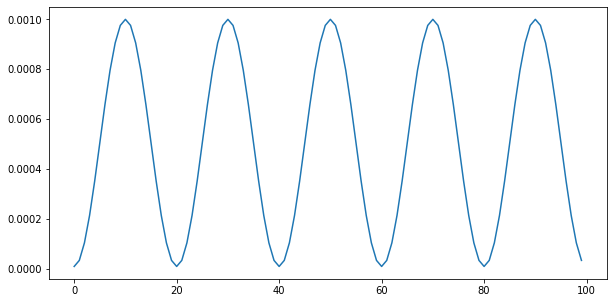

In [ ]:
scheduler = CosineAnnealingLR(optimizer, T_max=Config.T_max, eta_min=0.001)

log_s = []
for epoch in range(0, 100):
    log_s.append(scheduler.get_last_lr()[0])
    scheduler.step()

plt.figure(figsize=(10, 5))
plt.plot(np.arange(100), log_s)
plt.show()

## 損失関数（FocalLoss）

ハイパラ
gamma,eps

In [ ]:
class FocalLoss(nn.Module):

    def __init__(self, gamma=Config.gamma, eps=Config.eps):
        super(FocalLoss, self).__init__()
        self.gamma = gamma
        self.eps = eps
        self.ce = torch.nn.CrossEntropyLoss(reduction="none")

    def forward(self, input, target):
        logp = self.ce(input, target)
        p = torch.exp(-logp)
        loss = (1 - p) ** self.gamma * logp
        return loss.mean()

# 学習

In [ ]:
def train_loop(train, fold, class_num=None, norms=(0.5, 0.5)):
    
    train_index = train[train['folds'] != fold].index # 学習用のindex
    valid_index = train[train['folds'] == fold].index # 評価用のindex

    train_dataset = TrainDataset(train.loc[train_index].reset_index(drop=True), 
                                 transform=get_transforms(data='train', size=Config.size, norms=norms)) # 学習用のdatasetを作成
    valid_dataset = TrainDataset(train.loc[valid_index].reset_index(drop=True), 
                                 transform=get_transforms(data='valid', size=Config.size, norms=norms)) # 評価用のdatasetを作成

    train_loader = DataLoader(train_dataset, batch_size=Config.batch_size, shuffle=True, 
                              num_workers=Config.num_workers, pin_memory=True, drop_last=True)# 学習用のdatasetsのbatchを作成
    valid_loader = DataLoader(valid_dataset, batch_size=Config.batch_size, shuffle=False, 
                              num_workers=Config.num_workers, pin_memory=True, drop_last=False) # 評価用のdatasetsのbatchを作成
    
    
    model = BaseModel(Config.MODEL_NAME, class_num).to(Config.device)

    #optimizer = Adam(model.parameters(), lr=Config.model_lr, weight_decay=Config.weight_decay, amsgrad=False)
    #optimizer = AdamW(model.parameters(), lr=Config.model_lr, weight_decay=Config.weight_decay, amsgrad=False)
    optimizer = RAdam(model.parameters(), lr=Config.model_lr, weight_decay=Config.weight_decay)

    scheduler = CosineAnnealingLR(optimizer, T_max=Config.T_max, eta_min=Config.min_lr, last_epoch=-1)

    criterion = FocalLoss() # loss function was nn.CrossEntropyLoss()

    best_score = 0.
    best_loss = np.inf
    
    for epoch in range(Config.epochs):
        start_time = time.time()
        avg_loss = train_fn(train_loader, model, criterion, optimizer, epoch, scheduler) # 学習
        avg_val_loss, predict = valid_fn(valid_loader, model, criterion) # 評価用の推論
        valid_labels = train.loc[valid_index, "label"].values # 予測ラベル
        
        scheduler.step() 
        score = accuracy_score(valid_labels, predict) # 適合率を計算
        elapsed = time.time() - start_time

        LOGGER.info(f'Epoch {epoch+1} - avg_train_loss: {avg_loss:.4f}  avg_val_loss: {avg_val_loss:.4f}  time: {elapsed:.0f}s')
        LOGGER.info(f'Epoch {epoch+1} - Accuracy: {score}')

        if score > best_score:
            best_score = score
            LOGGER.info(f'Epoch {epoch+1} - Save Best Score: {best_score:.4f} Model')
            model_filename = f'{Config.model_dir}/{Config.MODEL_NAME}_fold{fold}_best_{Config.Version}.pth'
            torch.save(model.state_dict(), model_filename) # モデルの保存
            #torch.save(model.state_dict(), "./" + f'{Config.MODEL_NAME}_fold{fold}_best_{Config.Version}.pth') # モデルの保存
            print(f'{model_filename} saved')

            valid_folds_predict = predict
            
        del avg_loss, avg_val_loss, valid_labels, predict, score
        gc.collect()
        torch.cuda.empty_cache()

    return valid_folds_predict

In [ ]:
preds = train_loop(train, fold=Config.fold, class_num=Config.class_num, norms=Config.norms)

Epoch: [1][0/456] Data 1.424 (1.424) Elapsed 0m 2s (remain 19m 46s) Loss: 1.8933(1.8933) 
Epoch: [1][455/456] Data 0.000 (0.004) Elapsed 2m 47s (remain 0m 0s) Loss: 1.8078(1.8453) 
EVAL: [0/115] Data 0.687 (0.687) Elapsed 0m 0s (remain 1m 32s) Loss: 1.8103(1.8103) 
EVAL: [114/115] Data 0.000 (0.013) Elapsed 0m 12s (remain 0m 0s) Loss: 2.0973(1.9326) 


Epoch 1 - avg_train_loss: 1.8453  avg_val_loss: 1.9326  time: 182s
Epoch 1 - Accuracy: 0.14246575342465753
Epoch 1 - Save Best Score: 0.1425 Model


/content/drive/MyDrive/kaggla-za/E002Round3/Week2/AnimalImbalance/model/exp24/tf_efficientnet_b1_ns_fold0_best_exp24.pth saved
Epoch: [2][0/456] Data 0.718 (0.718) Elapsed 0m 1s (remain 10m 39s) Loss: 1.8175(1.8175) 
Epoch: [2][455/456] Data 0.000 (0.002) Elapsed 2m 43s (remain 0m 0s) Loss: 1.4917(1.6637) 
EVAL: [0/115] Data 0.504 (0.504) Elapsed 0m 0s (remain 1m 13s) Loss: 0.6910(0.6910) 
EVAL: [114/115] Data 0.000 (0.015) Elapsed 0m 13s (remain 0m 0s) Loss: 3.8600(1.5750) 


Epoch 2 - avg_train_loss: 1.6637  avg_val_loss: 1.5750  time: 178s
Epoch 2 - Accuracy: 0.2535616438356164
Epoch 2 - Save Best Score: 0.2536 Model


/content/drive/MyDrive/kaggla-za/E002Round3/Week2/AnimalImbalance/model/exp24/tf_efficientnet_b1_ns_fold0_best_exp24.pth saved
Epoch: [3][0/456] Data 0.802 (0.802) Elapsed 0m 1s (remain 11m 21s) Loss: 1.4799(1.4799) 
Epoch: [3][455/456] Data 0.000 (0.002) Elapsed 2m 44s (remain 0m 0s) Loss: 0.8006(1.1914) 
EVAL: [0/115] Data 0.688 (0.688) Elapsed 0m 0s (remain 1m 32s) Loss: 1.3016(1.3016) 
EVAL: [114/115] Data 0.000 (0.016) Elapsed 0m 12s (remain 0m 0s) Loss: 2.7136(1.1333) 


Epoch 3 - avg_train_loss: 1.1914  avg_val_loss: 1.1333  time: 178s
Epoch 3 - Accuracy: 0.3804109589041096
Epoch 3 - Save Best Score: 0.3804 Model


/content/drive/MyDrive/kaggla-za/E002Round3/Week2/AnimalImbalance/model/exp24/tf_efficientnet_b1_ns_fold0_best_exp24.pth saved
Epoch: [4][0/456] Data 0.810 (0.810) Elapsed 0m 1s (remain 11m 5s) Loss: 1.0200(1.0200) 
Epoch: [4][455/456] Data 0.000 (0.002) Elapsed 2m 44s (remain 0m 0s) Loss: 0.9091(0.9932) 
EVAL: [0/115] Data 0.625 (0.625) Elapsed 0m 0s (remain 1m 27s) Loss: 0.6565(0.6565) 
EVAL: [114/115] Data 0.000 (0.017) Elapsed 0m 13s (remain 0m 0s) Loss: 2.4385(0.8827) 


Epoch 4 - avg_train_loss: 0.9932  avg_val_loss: 0.8827  time: 178s
Epoch 4 - Accuracy: 0.49
Epoch 4 - Save Best Score: 0.4900 Model


/content/drive/MyDrive/kaggla-za/E002Round3/Week2/AnimalImbalance/model/exp24/tf_efficientnet_b1_ns_fold0_best_exp24.pth saved
Epoch: [5][0/456] Data 0.834 (0.834) Elapsed 0m 1s (remain 11m 9s) Loss: 1.0673(1.0673) 
Epoch: [5][455/456] Data 0.000 (0.002) Elapsed 2m 44s (remain 0m 0s) Loss: 0.6858(0.8524) 
EVAL: [0/115] Data 0.561 (0.561) Elapsed 0m 0s (remain 1m 20s) Loss: 0.4183(0.4183) 
EVAL: [114/115] Data 0.000 (0.017) Elapsed 0m 13s (remain 0m 0s) Loss: 2.1974(0.7624) 


Epoch 5 - avg_train_loss: 0.8524  avg_val_loss: 0.7624  time: 178s
Epoch 5 - Accuracy: 0.5457534246575343
Epoch 5 - Save Best Score: 0.5458 Model


/content/drive/MyDrive/kaggla-za/E002Round3/Week2/AnimalImbalance/model/exp24/tf_efficientnet_b1_ns_fold0_best_exp24.pth saved
Epoch: [6][0/456] Data 0.838 (0.838) Elapsed 0m 1s (remain 10m 50s) Loss: 0.7084(0.7084) 
Epoch: [6][455/456] Data 0.000 (0.002) Elapsed 2m 43s (remain 0m 0s) Loss: 0.5658(0.7304) 
EVAL: [0/115] Data 0.640 (0.640) Elapsed 0m 0s (remain 1m 24s) Loss: 0.4451(0.4451) 
EVAL: [114/115] Data 0.000 (0.018) Elapsed 0m 13s (remain 0m 0s) Loss: 1.4511(0.6665) 


Epoch 6 - avg_train_loss: 0.7304  avg_val_loss: 0.6665  time: 178s
Epoch 6 - Accuracy: 0.5917808219178082
Epoch 6 - Save Best Score: 0.5918 Model


/content/drive/MyDrive/kaggla-za/E002Round3/Week2/AnimalImbalance/model/exp24/tf_efficientnet_b1_ns_fold0_best_exp24.pth saved
Epoch: [7][0/456] Data 0.879 (0.879) Elapsed 0m 1s (remain 11m 13s) Loss: 0.7081(0.7081) 
Epoch: [7][455/456] Data 0.000 (0.002) Elapsed 2m 44s (remain 0m 0s) Loss: 0.4888(0.6378) 
EVAL: [0/115] Data 0.506 (0.506) Elapsed 0m 0s (remain 1m 12s) Loss: 0.4069(0.4069) 
EVAL: [114/115] Data 0.000 (0.018) Elapsed 0m 12s (remain 0m 0s) Loss: 1.1691(0.6220) 


Epoch 7 - avg_train_loss: 0.6378  avg_val_loss: 0.6220  time: 178s
Epoch 7 - Accuracy: 0.6346575342465753
Epoch 7 - Save Best Score: 0.6347 Model


/content/drive/MyDrive/kaggla-za/E002Round3/Week2/AnimalImbalance/model/exp24/tf_efficientnet_b1_ns_fold0_best_exp24.pth saved
Epoch: [8][0/456] Data 0.857 (0.857) Elapsed 0m 1s (remain 11m 32s) Loss: 0.7179(0.7179) 
Epoch: [8][455/456] Data 0.000 (0.002) Elapsed 2m 44s (remain 0m 0s) Loss: 0.4858(0.5581) 
EVAL: [0/115] Data 0.590 (0.590) Elapsed 0m 0s (remain 1m 22s) Loss: 0.3231(0.3231) 
EVAL: [114/115] Data 0.000 (0.015) Elapsed 0m 13s (remain 0m 0s) Loss: 1.6246(0.5387) 


Epoch 8 - avg_train_loss: 0.5581  avg_val_loss: 0.5387  time: 178s
Epoch 8 - Accuracy: 0.6724657534246575
Epoch 8 - Save Best Score: 0.6725 Model


/content/drive/MyDrive/kaggla-za/E002Round3/Week2/AnimalImbalance/model/exp24/tf_efficientnet_b1_ns_fold0_best_exp24.pth saved
Epoch: [9][0/456] Data 0.791 (0.791) Elapsed 0m 1s (remain 11m 3s) Loss: 0.4758(0.4758) 
Epoch: [9][455/456] Data 0.000 (0.002) Elapsed 2m 44s (remain 0m 0s) Loss: 0.5285(0.4965) 
EVAL: [0/115] Data 0.642 (0.642) Elapsed 0m 0s (remain 1m 28s) Loss: 0.4729(0.4729) 
EVAL: [114/115] Data 0.000 (0.014) Elapsed 0m 12s (remain 0m 0s) Loss: 0.2680(0.5220) 


Epoch 9 - avg_train_loss: 0.4965  avg_val_loss: 0.5220  time: 178s
Epoch 9 - Accuracy: 0.6828767123287671
Epoch 9 - Save Best Score: 0.6829 Model


/content/drive/MyDrive/kaggla-za/E002Round3/Week2/AnimalImbalance/model/exp24/tf_efficientnet_b1_ns_fold0_best_exp24.pth saved
Epoch: [10][0/456] Data 0.849 (0.849) Elapsed 0m 1s (remain 11m 37s) Loss: 0.5655(0.5655) 
Epoch: [10][455/456] Data 0.000 (0.002) Elapsed 2m 44s (remain 0m 0s) Loss: 0.4713(0.4384) 
EVAL: [0/115] Data 0.629 (0.629) Elapsed 0m 0s (remain 1m 26s) Loss: 0.2427(0.2427) 
EVAL: [114/115] Data 0.000 (0.017) Elapsed 0m 13s (remain 0m 0s) Loss: 1.0026(0.4985) 


Epoch 10 - avg_train_loss: 0.4384  avg_val_loss: 0.4985  time: 178s
Epoch 10 - Accuracy: 0.6995890410958904
Epoch 10 - Save Best Score: 0.6996 Model


/content/drive/MyDrive/kaggla-za/E002Round3/Week2/AnimalImbalance/model/exp24/tf_efficientnet_b1_ns_fold0_best_exp24.pth saved
Epoch: [11][0/456] Data 0.845 (0.845) Elapsed 0m 1s (remain 11m 7s) Loss: 0.3776(0.3776) 
Epoch: [11][455/456] Data 0.000 (0.002) Elapsed 2m 44s (remain 0m 0s) Loss: 0.2314(0.3953) 
EVAL: [0/115] Data 0.539 (0.539) Elapsed 0m 0s (remain 1m 18s) Loss: 0.4795(0.4795) 
EVAL: [114/115] Data 0.000 (0.012) Elapsed 0m 13s (remain 0m 0s) Loss: 0.3779(0.4105) 


Epoch 11 - avg_train_loss: 0.3953  avg_val_loss: 0.4105  time: 178s
Epoch 11 - Accuracy: 0.7368493150684932
Epoch 11 - Save Best Score: 0.7368 Model


/content/drive/MyDrive/kaggla-za/E002Round3/Week2/AnimalImbalance/model/exp24/tf_efficientnet_b1_ns_fold0_best_exp24.pth saved
Epoch: [12][0/456] Data 0.701 (0.701) Elapsed 0m 1s (remain 10m 35s) Loss: 0.3335(0.3335) 
Epoch: [12][455/456] Data 0.000 (0.002) Elapsed 2m 43s (remain 0m 0s) Loss: 0.4398(0.3519) 
EVAL: [0/115] Data 0.529 (0.529) Elapsed 0m 0s (remain 1m 16s) Loss: 0.3545(0.3545) 
EVAL: [114/115] Data 0.000 (0.016) Elapsed 0m 13s (remain 0m 0s) Loss: 0.1778(0.3586) 


Epoch 12 - avg_train_loss: 0.3519  avg_val_loss: 0.3586  time: 178s
Epoch 12 - Accuracy: 0.7682191780821918
Epoch 12 - Save Best Score: 0.7682 Model


/content/drive/MyDrive/kaggla-za/E002Round3/Week2/AnimalImbalance/model/exp24/tf_efficientnet_b1_ns_fold0_best_exp24.pth saved
Epoch: [13][0/456] Data 0.739 (0.739) Elapsed 0m 1s (remain 10m 49s) Loss: 0.3707(0.3707) 
Epoch: [13][455/456] Data 0.000 (0.002) Elapsed 2m 44s (remain 0m 0s) Loss: 0.2300(0.3185) 
EVAL: [0/115] Data 0.528 (0.528) Elapsed 0m 0s (remain 1m 16s) Loss: 0.2376(0.2376) 
EVAL: [114/115] Data 0.000 (0.017) Elapsed 0m 13s (remain 0m 0s) Loss: 0.1747(0.3741) 


Epoch 13 - avg_train_loss: 0.3185  avg_val_loss: 0.3741  time: 178s
Epoch 13 - Accuracy: 0.7517808219178083


Epoch: [14][0/456] Data 0.585 (0.585) Elapsed 0m 1s (remain 9m 37s) Loss: 0.2310(0.2310) 
Epoch: [14][455/456] Data 0.000 (0.002) Elapsed 2m 43s (remain 0m 0s) Loss: 0.4007(0.2774) 
EVAL: [0/115] Data 0.598 (0.598) Elapsed 0m 0s (remain 1m 22s) Loss: 0.1580(0.1580) 
EVAL: [114/115] Data 0.000 (0.017) Elapsed 0m 12s (remain 0m 0s) Loss: 0.0236(0.3163) 


Epoch 14 - avg_train_loss: 0.2774  avg_val_loss: 0.3163  time: 177s
Epoch 14 - Accuracy: 0.7887671232876712
Epoch 14 - Save Best Score: 0.7888 Model


/content/drive/MyDrive/kaggla-za/E002Round3/Week2/AnimalImbalance/model/exp24/tf_efficientnet_b1_ns_fold0_best_exp24.pth saved
Epoch: [15][0/456] Data 0.929 (0.929) Elapsed 0m 1s (remain 11m 32s) Loss: 0.2292(0.2292) 
Epoch: [15][455/456] Data 0.000 (0.002) Elapsed 2m 44s (remain 0m 0s) Loss: 0.3523(0.2441) 
EVAL: [0/115] Data 0.580 (0.580) Elapsed 0m 0s (remain 1m 21s) Loss: 0.2207(0.2207) 
EVAL: [114/115] Data 0.000 (0.017) Elapsed 0m 13s (remain 0m 0s) Loss: 0.1832(0.2956) 


Epoch 15 - avg_train_loss: 0.2441  avg_val_loss: 0.2956  time: 178s
Epoch 15 - Accuracy: 0.8005479452054794
Epoch 15 - Save Best Score: 0.8005 Model


/content/drive/MyDrive/kaggla-za/E002Round3/Week2/AnimalImbalance/model/exp24/tf_efficientnet_b1_ns_fold0_best_exp24.pth saved
Epoch: [16][0/456] Data 0.663 (0.663) Elapsed 0m 1s (remain 10m 46s) Loss: 0.2585(0.2585) 
Epoch: [16][455/456] Data 0.000 (0.002) Elapsed 2m 44s (remain 0m 0s) Loss: 0.3153(0.2017) 
EVAL: [0/115] Data 0.463 (0.463) Elapsed 0m 0s (remain 1m 2s) Loss: 0.1204(0.1204) 
EVAL: [114/115] Data 0.000 (0.017) Elapsed 0m 13s (remain 0m 0s) Loss: 0.0194(0.2858) 


Epoch 16 - avg_train_loss: 0.2017  avg_val_loss: 0.2858  time: 178s
Epoch 16 - Accuracy: 0.8156164383561644
Epoch 16 - Save Best Score: 0.8156 Model


/content/drive/MyDrive/kaggla-za/E002Round3/Week2/AnimalImbalance/model/exp24/tf_efficientnet_b1_ns_fold0_best_exp24.pth saved
Epoch: [17][0/456] Data 0.840 (0.840) Elapsed 0m 1s (remain 11m 40s) Loss: 0.1313(0.1313) 
Epoch: [17][455/456] Data 0.000 (0.002) Elapsed 2m 44s (remain 0m 0s) Loss: 0.2591(0.1627) 
EVAL: [0/115] Data 0.683 (0.683) Elapsed 0m 0s (remain 1m 29s) Loss: 0.1670(0.1670) 
EVAL: [114/115] Data 0.000 (0.017) Elapsed 0m 13s (remain 0m 0s) Loss: 0.0763(0.2605) 


Epoch 17 - avg_train_loss: 0.1627  avg_val_loss: 0.2605  time: 178s
Epoch 17 - Accuracy: 0.8326027397260274
Epoch 17 - Save Best Score: 0.8326 Model


/content/drive/MyDrive/kaggla-za/E002Round3/Week2/AnimalImbalance/model/exp24/tf_efficientnet_b1_ns_fold0_best_exp24.pth saved
Epoch: [18][0/456] Data 0.746 (0.746) Elapsed 0m 1s (remain 11m 13s) Loss: 0.0913(0.0913) 
Epoch: [18][455/456] Data 0.000 (0.002) Elapsed 2m 44s (remain 0m 0s) Loss: 0.1253(0.1323) 
EVAL: [0/115] Data 0.712 (0.712) Elapsed 0m 0s (remain 1m 36s) Loss: 0.2303(0.2303) 
EVAL: [114/115] Data 0.000 (0.015) Elapsed 0m 13s (remain 0m 0s) Loss: 0.1218(0.2551) 


Epoch 18 - avg_train_loss: 0.1323  avg_val_loss: 0.2551  time: 178s
Epoch 18 - Accuracy: 0.8421917808219178
Epoch 18 - Save Best Score: 0.8422 Model


/content/drive/MyDrive/kaggla-za/E002Round3/Week2/AnimalImbalance/model/exp24/tf_efficientnet_b1_ns_fold0_best_exp24.pth saved
Epoch: [19][0/456] Data 0.691 (0.691) Elapsed 0m 1s (remain 10m 48s) Loss: 0.0895(0.0895) 
Epoch: [19][455/456] Data 0.000 (0.002) Elapsed 2m 43s (remain 0m 0s) Loss: 0.1226(0.1089) 
EVAL: [0/115] Data 0.703 (0.703) Elapsed 0m 0s (remain 1m 34s) Loss: 0.1746(0.1746) 
EVAL: [114/115] Data 0.000 (0.014) Elapsed 0m 12s (remain 0m 0s) Loss: 0.0434(0.2322) 


Epoch 19 - avg_train_loss: 0.1089  avg_val_loss: 0.2322  time: 178s
Epoch 19 - Accuracy: 0.8508219178082191
Epoch 19 - Save Best Score: 0.8508 Model


/content/drive/MyDrive/kaggla-za/E002Round3/Week2/AnimalImbalance/model/exp24/tf_efficientnet_b1_ns_fold0_best_exp24.pth saved
Epoch: [20][0/456] Data 0.694 (0.694) Elapsed 0m 1s (remain 10m 43s) Loss: 0.0644(0.0644) 
Epoch: [20][455/456] Data 0.000 (0.002) Elapsed 2m 44s (remain 0m 0s) Loss: 0.0780(0.0929) 
EVAL: [0/115] Data 0.519 (0.519) Elapsed 0m 0s (remain 1m 13s) Loss: 0.1598(0.1598) 
EVAL: [114/115] Data 0.000 (0.017) Elapsed 0m 13s (remain 0m 0s) Loss: 0.0423(0.2288) 


Epoch 20 - avg_train_loss: 0.0929  avg_val_loss: 0.2288  time: 178s
Epoch 20 - Accuracy: 0.8552054794520548
Epoch 20 - Save Best Score: 0.8552 Model


/content/drive/MyDrive/kaggla-za/E002Round3/Week2/AnimalImbalance/model/exp24/tf_efficientnet_b1_ns_fold0_best_exp24.pth saved
Epoch: [21][0/456] Data 0.755 (0.755) Elapsed 0m 1s (remain 10m 57s) Loss: 0.0775(0.0775) 
Epoch: [21][455/456] Data 0.000 (0.002) Elapsed 2m 44s (remain 0m 0s) Loss: 0.0778(0.0860) 
EVAL: [0/115] Data 0.615 (0.615) Elapsed 0m 0s (remain 1m 25s) Loss: 0.1658(0.1658) 
EVAL: [114/115] Data 0.000 (0.017) Elapsed 0m 12s (remain 0m 0s) Loss: 0.0377(0.2273) 


Epoch 21 - avg_train_loss: 0.0860  avg_val_loss: 0.2273  time: 178s
Epoch 21 - Accuracy: 0.8550684931506849


Epoch: [22][0/456] Data 0.716 (0.716) Elapsed 0m 1s (remain 10m 32s) Loss: 0.1237(0.1237) 
Epoch: [22][455/456] Data 0.000 (0.002) Elapsed 2m 44s (remain 0m 0s) Loss: 0.0420(0.0854) 
EVAL: [0/115] Data 0.693 (0.693) Elapsed 0m 0s (remain 1m 31s) Loss: 0.1750(0.1750) 
EVAL: [114/115] Data 0.000 (0.015) Elapsed 0m 13s (remain 0m 0s) Loss: 0.0265(0.2295) 


Epoch 22 - avg_train_loss: 0.0854  avg_val_loss: 0.2295  time: 178s
Epoch 22 - Accuracy: 0.8561643835616438
Epoch 22 - Save Best Score: 0.8562 Model


/content/drive/MyDrive/kaggla-za/E002Round3/Week2/AnimalImbalance/model/exp24/tf_efficientnet_b1_ns_fold0_best_exp24.pth saved
Epoch: [23][0/456] Data 0.788 (0.788) Elapsed 0m 1s (remain 11m 4s) Loss: 0.0486(0.0486) 
Epoch: [23][455/456] Data 0.000 (0.002) Elapsed 2m 44s (remain 0m 0s) Loss: 0.1127(0.0891) 
EVAL: [0/115] Data 0.536 (0.536) Elapsed 0m 0s (remain 1m 16s) Loss: 0.2192(0.2192) 
EVAL: [114/115] Data 0.000 (0.016) Elapsed 0m 13s (remain 0m 0s) Loss: 0.0863(0.2412) 


Epoch 23 - avg_train_loss: 0.0891  avg_val_loss: 0.2412  time: 178s
Epoch 23 - Accuracy: 0.85


Epoch: [24][0/456] Data 0.754 (0.754) Elapsed 0m 1s (remain 11m 4s) Loss: 0.0991(0.0991) 
Epoch: [24][455/456] Data 0.000 (0.002) Elapsed 2m 44s (remain 0m 0s) Loss: 0.2269(0.1053) 
EVAL: [0/115] Data 0.653 (0.653) Elapsed 0m 0s (remain 1m 29s) Loss: 0.1643(0.1643) 
EVAL: [114/115] Data 0.000 (0.016) Elapsed 0m 13s (remain 0m 0s) Loss: 0.0982(0.2585) 


Epoch 24 - avg_train_loss: 0.1053  avg_val_loss: 0.2585  time: 178s
Epoch 24 - Accuracy: 0.8379452054794521


Epoch: [25][0/456] Data 0.724 (0.724) Elapsed 0m 1s (remain 10m 53s) Loss: 0.0636(0.0636) 
Epoch: [25][455/456] Data 0.000 (0.002) Elapsed 2m 44s (remain 0m 0s) Loss: 0.1420(0.1213) 
EVAL: [0/115] Data 0.660 (0.660) Elapsed 0m 0s (remain 1m 30s) Loss: 0.1691(0.1691) 
EVAL: [114/115] Data 0.000 (0.017) Elapsed 0m 13s (remain 0m 0s) Loss: 0.0018(0.2810) 


Epoch 25 - avg_train_loss: 0.1213  avg_val_loss: 0.2810  time: 178s
Epoch 25 - Accuracy: 0.823013698630137


Epoch: [26][0/456] Data 0.686 (0.686) Elapsed 0m 1s (remain 10m 21s) Loss: 0.1478(0.1478) 
Epoch: [26][455/456] Data 0.000 (0.002) Elapsed 2m 44s (remain 0m 0s) Loss: 0.1838(0.1441) 
EVAL: [0/115] Data 0.599 (0.599) Elapsed 0m 0s (remain 1m 22s) Loss: 0.1973(0.1973) 
EVAL: [114/115] Data 0.000 (0.021) Elapsed 0m 13s (remain 0m 0s) Loss: 0.4459(0.2912) 


Epoch 26 - avg_train_loss: 0.1441  avg_val_loss: 0.2912  time: 178s
Epoch 26 - Accuracy: 0.8236986301369863


Epoch: [27][0/456] Data 0.863 (0.863) Elapsed 0m 1s (remain 11m 58s) Loss: 0.0881(0.0881) 
Epoch: [27][455/456] Data 0.000 (0.002) Elapsed 2m 44s (remain 0m 0s) Loss: 0.2410(0.1631) 
EVAL: [0/115] Data 0.665 (0.665) Elapsed 0m 0s (remain 1m 33s) Loss: 0.3289(0.3289) 
EVAL: [114/115] Data 0.000 (0.018) Elapsed 0m 13s (remain 0m 0s) Loss: 0.0023(0.2846) 


Epoch 27 - avg_train_loss: 0.1631  avg_val_loss: 0.2846  time: 178s
Epoch 27 - Accuracy: 0.8231506849315069


Epoch: [28][0/456] Data 0.878 (0.878) Elapsed 0m 1s (remain 12m 10s) Loss: 0.1089(0.1089) 
Epoch: [28][455/456] Data 0.000 (0.002) Elapsed 2m 44s (remain 0m 0s) Loss: 0.0773(0.1771) 
EVAL: [0/115] Data 0.573 (0.573) Elapsed 0m 0s (remain 1m 23s) Loss: 0.2033(0.2033) 
EVAL: [114/115] Data 0.000 (0.018) Elapsed 0m 13s (remain 0m 0s) Loss: 0.0401(0.2809) 


Epoch 28 - avg_train_loss: 0.1771  avg_val_loss: 0.2809  time: 178s
Epoch 28 - Accuracy: 0.823013698630137


Epoch: [29][0/456] Data 0.467 (0.467) Elapsed 0m 1s (remain 8m 35s) Loss: 0.2224(0.2224) 
Epoch: [29][455/456] Data 0.000 (0.001) Elapsed 2m 43s (remain 0m 0s) Loss: 0.1566(0.1807) 
EVAL: [0/115] Data 0.643 (0.643) Elapsed 0m 0s (remain 1m 28s) Loss: 0.1439(0.1439) 
EVAL: [114/115] Data 0.000 (0.020) Elapsed 0m 13s (remain 0m 0s) Loss: 0.0482(0.2988) 


Epoch 29 - avg_train_loss: 0.1807  avg_val_loss: 0.2988  time: 178s
Epoch 29 - Accuracy: 0.8157534246575342


Epoch: [30][0/456] Data 0.829 (0.829) Elapsed 0m 1s (remain 11m 1s) Loss: 0.2339(0.2339) 
Epoch: [30][455/456] Data 0.000 (0.002) Elapsed 2m 44s (remain 0m 0s) Loss: 0.2251(0.1786) 
EVAL: [0/115] Data 0.614 (0.614) Elapsed 0m 0s (remain 1m 24s) Loss: 0.0802(0.0802) 
EVAL: [114/115] Data 0.000 (0.017) Elapsed 0m 13s (remain 0m 0s) Loss: 0.0314(0.3123) 


Epoch 30 - avg_train_loss: 0.1786  avg_val_loss: 0.3123  time: 178s
Epoch 30 - Accuracy: 0.7971232876712329


Epoch: [31][0/456] Data 0.738 (0.738) Elapsed 0m 1s (remain 11m 33s) Loss: 0.1700(0.1700) 
Epoch: [31][455/456] Data 0.000 (0.002) Elapsed 2m 44s (remain 0m 0s) Loss: 0.0775(0.1710) 
EVAL: [0/115] Data 0.531 (0.531) Elapsed 0m 0s (remain 1m 16s) Loss: 0.1514(0.1514) 
EVAL: [114/115] Data 0.000 (0.017) Elapsed 0m 13s (remain 0m 0s) Loss: 0.0003(0.2771) 


Epoch 31 - avg_train_loss: 0.1710  avg_val_loss: 0.2771  time: 178s
Epoch 31 - Accuracy: 0.8186301369863014


Epoch: [32][0/456] Data 0.845 (0.845) Elapsed 0m 1s (remain 11m 16s) Loss: 0.1476(0.1476) 
Epoch: [32][455/456] Data 0.000 (0.002) Elapsed 2m 44s (remain 0m 0s) Loss: 0.0495(0.1586) 
EVAL: [0/115] Data 0.519 (0.519) Elapsed 0m 0s (remain 1m 16s) Loss: 0.2036(0.2036) 
EVAL: [114/115] Data 0.000 (0.018) Elapsed 0m 13s (remain 0m 0s) Loss: 0.1792(0.2482) 


Epoch 32 - avg_train_loss: 0.1586  avg_val_loss: 0.2482  time: 178s
Epoch 32 - Accuracy: 0.8402739726027397


Epoch: [33][0/456] Data 0.828 (0.828) Elapsed 0m 1s (remain 11m 31s) Loss: 0.1519(0.1519) 
Epoch: [33][455/456] Data 0.000 (0.002) Elapsed 2m 44s (remain 0m 0s) Loss: 0.2030(0.1394) 
EVAL: [0/115] Data 0.508 (0.508) Elapsed 0m 0s (remain 1m 14s) Loss: 0.2765(0.2765) 
EVAL: [114/115] Data 0.000 (0.018) Elapsed 0m 13s (remain 0m 0s) Loss: 0.0284(0.2777) 


Epoch 33 - avg_train_loss: 0.1394  avg_val_loss: 0.2777  time: 178s
Epoch 33 - Accuracy: 0.824931506849315


Epoch: [34][0/456] Data 0.726 (0.726) Elapsed 0m 1s (remain 10m 45s) Loss: 0.1976(0.1976) 
Epoch: [34][455/456] Data 0.000 (0.002) Elapsed 2m 44s (remain 0m 0s) Loss: 0.0744(0.1174) 
EVAL: [0/115] Data 0.678 (0.678) Elapsed 0m 0s (remain 1m 31s) Loss: 0.1477(0.1477) 
EVAL: [114/115] Data 0.000 (0.018) Elapsed 0m 13s (remain 0m 0s) Loss: 0.1194(0.2504) 


Epoch 34 - avg_train_loss: 0.1174  avg_val_loss: 0.2504  time: 178s
Epoch 34 - Accuracy: 0.8441095890410959


Epoch: [35][0/456] Data 0.719 (0.719) Elapsed 0m 1s (remain 10m 58s) Loss: 0.0703(0.0703) 
Epoch: [35][455/456] Data 0.000 (0.002) Elapsed 2m 44s (remain 0m 0s) Loss: 0.1153(0.0933) 
EVAL: [0/115] Data 0.528 (0.528) Elapsed 0m 0s (remain 1m 20s) Loss: 0.0842(0.0842) 
EVAL: [114/115] Data 0.000 (0.017) Elapsed 0m 13s (remain 0m 0s) Loss: 0.0064(0.2395) 


Epoch 35 - avg_train_loss: 0.0933  avg_val_loss: 0.2395  time: 178s
Epoch 35 - Accuracy: 0.8493150684931506


Epoch: [36][0/456] Data 0.446 (0.446) Elapsed 0m 1s (remain 8m 16s) Loss: 0.1066(0.1066) 
Epoch: [36][455/456] Data 0.000 (0.001) Elapsed 2m 43s (remain 0m 0s) Loss: 0.1253(0.0732) 
EVAL: [0/115] Data 0.646 (0.646) Elapsed 0m 0s (remain 1m 25s) Loss: 0.1372(0.1372) 
EVAL: [114/115] Data 0.000 (0.016) Elapsed 0m 13s (remain 0m 0s) Loss: 0.0128(0.2307) 


Epoch 36 - avg_train_loss: 0.0732  avg_val_loss: 0.2307  time: 178s
Epoch 36 - Accuracy: 0.8642465753424657
Epoch 36 - Save Best Score: 0.8642 Model


/content/drive/MyDrive/kaggla-za/E002Round3/Week2/AnimalImbalance/model/exp24/tf_efficientnet_b1_ns_fold0_best_exp24.pth saved
Epoch: [37][0/456] Data 0.677 (0.677) Elapsed 0m 1s (remain 10m 34s) Loss: 0.0426(0.0426) 
Epoch: [37][455/456] Data 0.000 (0.002) Elapsed 2m 44s (remain 0m 0s) Loss: 0.0684(0.0525) 
EVAL: [0/115] Data 0.731 (0.731) Elapsed 0m 0s (remain 1m 33s) Loss: 0.1493(0.1493) 
EVAL: [114/115] Data 0.000 (0.017) Elapsed 0m 13s (remain 0m 0s) Loss: 0.3371(0.2331) 


Epoch 37 - avg_train_loss: 0.0525  avg_val_loss: 0.2331  time: 178s
Epoch 37 - Accuracy: 0.8671232876712329
Epoch 37 - Save Best Score: 0.8671 Model


/content/drive/MyDrive/kaggla-za/E002Round3/Week2/AnimalImbalance/model/exp24/tf_efficientnet_b1_ns_fold0_best_exp24.pth saved
Epoch: [38][0/456] Data 0.744 (0.744) Elapsed 0m 1s (remain 11m 29s) Loss: 0.0389(0.0389) 
Epoch: [38][455/456] Data 0.000 (0.002) Elapsed 2m 44s (remain 0m 0s) Loss: 0.0332(0.0406) 
EVAL: [0/115] Data 0.529 (0.529) Elapsed 0m 0s (remain 1m 19s) Loss: 0.1226(0.1226) 
EVAL: [114/115] Data 0.000 (0.016) Elapsed 0m 13s (remain 0m 0s) Loss: 0.0244(0.2287) 


Epoch 38 - avg_train_loss: 0.0406  avg_val_loss: 0.2287  time: 178s
Epoch 38 - Accuracy: 0.8684931506849315
Epoch 38 - Save Best Score: 0.8685 Model


/content/drive/MyDrive/kaggla-za/E002Round3/Week2/AnimalImbalance/model/exp24/tf_efficientnet_b1_ns_fold0_best_exp24.pth saved
Epoch: [39][0/456] Data 0.894 (0.894) Elapsed 0m 1s (remain 11m 0s) Loss: 0.0372(0.0372) 
Epoch: [39][455/456] Data 0.000 (0.002) Elapsed 2m 44s (remain 0m 0s) Loss: 0.0940(0.0302) 
EVAL: [0/115] Data 0.532 (0.532) Elapsed 0m 0s (remain 1m 18s) Loss: 0.1366(0.1366) 
EVAL: [114/115] Data 0.000 (0.018) Elapsed 0m 13s (remain 0m 0s) Loss: 0.0172(0.2219) 


Epoch 39 - avg_train_loss: 0.0302  avg_val_loss: 0.2219  time: 178s
Epoch 39 - Accuracy: 0.8794520547945206
Epoch 39 - Save Best Score: 0.8795 Model


/content/drive/MyDrive/kaggla-za/E002Round3/Week2/AnimalImbalance/model/exp24/tf_efficientnet_b1_ns_fold0_best_exp24.pth saved
Epoch: [40][0/456] Data 0.843 (0.843) Elapsed 0m 1s (remain 11m 5s) Loss: 0.0296(0.0296) 
Epoch: [40][455/456] Data 0.000 (0.002) Elapsed 2m 44s (remain 0m 0s) Loss: 0.0119(0.0250) 
EVAL: [0/115] Data 0.732 (0.732) Elapsed 0m 0s (remain 1m 36s) Loss: 0.1032(0.1032) 
EVAL: [114/115] Data 0.000 (0.018) Elapsed 0m 13s (remain 0m 0s) Loss: 0.0257(0.2183) 


Epoch 40 - avg_train_loss: 0.0250  avg_val_loss: 0.2183  time: 178s
Epoch 40 - Accuracy: 0.88
Epoch 40 - Save Best Score: 0.8800 Model


/content/drive/MyDrive/kaggla-za/E002Round3/Week2/AnimalImbalance/model/exp24/tf_efficientnet_b1_ns_fold0_best_exp24.pth saved
Epoch: [41][0/456] Data 0.557 (0.557) Elapsed 0m 1s (remain 9m 31s) Loss: 0.0357(0.0357) 
Epoch: [41][455/456] Data 0.000 (0.001) Elapsed 2m 43s (remain 0m 0s) Loss: 0.0103(0.0217) 
EVAL: [0/115] Data 0.509 (0.509) Elapsed 0m 0s (remain 1m 13s) Loss: 0.1109(0.1109) 
EVAL: [114/115] Data 0.000 (0.017) Elapsed 0m 12s (remain 0m 0s) Loss: 0.0465(0.2191) 


Epoch 41 - avg_train_loss: 0.0217  avg_val_loss: 0.2191  time: 178s
Epoch 41 - Accuracy: 0.8826027397260274
Epoch 41 - Save Best Score: 0.8826 Model


/content/drive/MyDrive/kaggla-za/E002Round3/Week2/AnimalImbalance/model/exp24/tf_efficientnet_b1_ns_fold0_best_exp24.pth saved
Epoch: [42][0/456] Data 0.788 (0.788) Elapsed 0m 1s (remain 11m 39s) Loss: 0.0104(0.0104) 
Epoch: [42][455/456] Data 0.000 (0.002) Elapsed 2m 44s (remain 0m 0s) Loss: 0.0284(0.0231) 
EVAL: [0/115] Data 0.523 (0.523) Elapsed 0m 0s (remain 1m 13s) Loss: 0.0970(0.0970) 
EVAL: [114/115] Data 0.000 (0.015) Elapsed 0m 13s (remain 0m 0s) Loss: 0.0504(0.2226) 


Epoch 42 - avg_train_loss: 0.0231  avg_val_loss: 0.2226  time: 178s
Epoch 42 - Accuracy: 0.8816438356164383


Epoch: [43][0/456] Data 0.850 (0.850) Elapsed 0m 1s (remain 11m 46s) Loss: 0.0125(0.0125) 
Epoch: [43][455/456] Data 0.000 (0.002) Elapsed 2m 44s (remain 0m 0s) Loss: 0.0272(0.0240) 
EVAL: [0/115] Data 0.660 (0.660) Elapsed 0m 0s (remain 1m 32s) Loss: 0.1428(0.1428) 
EVAL: [114/115] Data 0.000 (0.013) Elapsed 0m 13s (remain 0m 0s) Loss: 0.0235(0.2287) 


Epoch 43 - avg_train_loss: 0.0240  avg_val_loss: 0.2287  time: 178s
Epoch 43 - Accuracy: 0.8782191780821917


Epoch: [44][0/456] Data 0.715 (0.715) Elapsed 0m 1s (remain 10m 54s) Loss: 0.0529(0.0529) 
Epoch: [44][455/456] Data 0.000 (0.002) Elapsed 2m 44s (remain 0m 0s) Loss: 0.0097(0.0291) 
EVAL: [0/115] Data 0.564 (0.564) Elapsed 0m 0s (remain 1m 20s) Loss: 0.2277(0.2277) 
EVAL: [114/115] Data 0.000 (0.020) Elapsed 0m 13s (remain 0m 0s) Loss: 0.0444(0.2505) 


Epoch 44 - avg_train_loss: 0.0291  avg_val_loss: 0.2505  time: 178s
Epoch 44 - Accuracy: 0.8731506849315068


Epoch: [45][0/456] Data 0.682 (0.682) Elapsed 0m 1s (remain 10m 45s) Loss: 0.0329(0.0329) 
Epoch: [45][455/456] Data 0.000 (0.002) Elapsed 2m 44s (remain 0m 0s) Loss: 0.0283(0.0456) 
EVAL: [0/115] Data 0.518 (0.518) Elapsed 0m 0s (remain 1m 15s) Loss: 0.1666(0.1666) 
EVAL: [114/115] Data 0.000 (0.018) Elapsed 0m 13s (remain 0m 0s) Loss: 0.3324(0.2694) 


Epoch 45 - avg_train_loss: 0.0456  avg_val_loss: 0.2694  time: 178s
Epoch 45 - Accuracy: 0.8615068493150685


Epoch: [46][0/456] Data 0.620 (0.620) Elapsed 0m 1s (remain 10m 11s) Loss: 0.0638(0.0638) 
Epoch: [46][455/456] Data 0.000 (0.002) Elapsed 2m 44s (remain 0m 0s) Loss: 0.0368(0.0635) 
EVAL: [0/115] Data 0.618 (0.618) Elapsed 0m 0s (remain 1m 28s) Loss: 0.2227(0.2227) 
EVAL: [114/115] Data 0.000 (0.018) Elapsed 0m 13s (remain 0m 0s) Loss: 0.0094(0.2623) 


Epoch 46 - avg_train_loss: 0.0635  avg_val_loss: 0.2623  time: 178s
Epoch 46 - Accuracy: 0.8612328767123287


Epoch: [47][0/456] Data 0.715 (0.715) Elapsed 0m 1s (remain 10m 45s) Loss: 0.0385(0.0385) 
Epoch: [47][455/456] Data 0.000 (0.002) Elapsed 2m 44s (remain 0m 0s) Loss: 0.0690(0.0812) 
EVAL: [0/115] Data 0.713 (0.713) Elapsed 0m 0s (remain 1m 31s) Loss: 0.1612(0.1612) 
EVAL: [114/115] Data 0.000 (0.018) Elapsed 0m 13s (remain 0m 0s) Loss: 0.0001(0.2547) 


Epoch 47 - avg_train_loss: 0.0812  avg_val_loss: 0.2547  time: 178s
Epoch 47 - Accuracy: 0.8467123287671233


Epoch: [48][0/456] Data 0.890 (0.890) Elapsed 0m 1s (remain 11m 1s) Loss: 0.0792(0.0792) 
Epoch: [48][455/456] Data 0.000 (0.002) Elapsed 2m 44s (remain 0m 0s) Loss: 0.1059(0.0959) 
EVAL: [0/115] Data 0.746 (0.746) Elapsed 0m 0s (remain 1m 37s) Loss: 0.2303(0.2303) 
EVAL: [114/115] Data 0.000 (0.019) Elapsed 0m 13s (remain 0m 0s) Loss: 0.0013(0.2872) 


Epoch 48 - avg_train_loss: 0.0959  avg_val_loss: 0.2872  time: 178s
Epoch 48 - Accuracy: 0.8373972602739727


Epoch: [49][0/456] Data 0.822 (0.822) Elapsed 0m 1s (remain 11m 17s) Loss: 0.0399(0.0399) 
Epoch: [49][455/456] Data 0.000 (0.002) Elapsed 2m 44s (remain 0m 0s) Loss: 0.0475(0.1010) 
EVAL: [0/115] Data 0.441 (0.441) Elapsed 0m 0s (remain 0m 59s) Loss: 0.2124(0.2124) 
EVAL: [114/115] Data 0.000 (0.015) Elapsed 0m 13s (remain 0m 0s) Loss: 0.0199(0.2505) 


Epoch 49 - avg_train_loss: 0.1010  avg_val_loss: 0.2505  time: 178s
Epoch 49 - Accuracy: 0.8521917808219178


Epoch: [50][0/456] Data 0.847 (0.847) Elapsed 0m 1s (remain 10m 58s) Loss: 0.0700(0.0700) 
Epoch: [50][455/456] Data 0.000 (0.002) Elapsed 2m 44s (remain 0m 0s) Loss: 0.0612(0.1030) 
EVAL: [0/115] Data 0.699 (0.699) Elapsed 0m 0s (remain 1m 38s) Loss: 0.0847(0.0847) 
EVAL: [114/115] Data 0.000 (0.014) Elapsed 0m 13s (remain 0m 0s) Loss: 0.0084(0.2745) 


Epoch 50 - avg_train_loss: 0.1030  avg_val_loss: 0.2745  time: 178s
Epoch 50 - Accuracy: 0.8413698630136986


# 推論

In [ ]:
def inference(test, class_num=Config.class_num, n=0, norms=(0.5, 0.5)):
    model = BaseModel(Config.MODEL_NAME, class_num, pretrained=False)

    model.load_state_dict(torch.load(f'{Config.model_dir}/{Config.MODEL_NAME}_fold{n}_best_{Config.Version}.pth')) # 重みの読み込み
    model.to(Config.device)
    
    test_dataset = TestDataset(test, transform=get_transforms(data='valid', size=Config.size, norms=norms))
    test_loader = DataLoader(test_dataset, batch_size=Config.batch_size, shuffle=False, num_workers=Config.num_workers)
    
    all_predicts = []
    model.eval() # 推論モード
    with torch.no_grad(): # 勾配の計算をしない
        for i, (images) in tqdm(enumerate(test_loader), total=len(test_loader)):
            images = images.to(Config.device)
            y_preds = model(images)
            predicts = y_preds.softmax(1).to("cpu").numpy().argmax(1)
            all_predicts.append(predicts)
    
    predicts = np.concatenate(all_predicts)
        
    return predicts

In [ ]:
#MODEL_PATH = "./" # 自身の作成したモデルへのPATH

#修正
if ON_KAGGLE:
    #test = pd.read_csv(Config.data_dir + "/test.csv")
    test = pd.read_csv(Config.data_dir + "/sample_submission.csv")
    test['image_id'] = Config.data_dir + '/test_images/' + test['image_id']
else:
    #test = pd.read_csv(f'{Config.data_dir}/test/test.csv')
    test = pd.read_csv(f'{Config.data_dir}/sample_submission.csv')
    test['image_id'] = Config.data_dir + '/test_images/' + test['image_id']

In [ ]:
predicts = inference(test, class_num=Config.class_num, n=0, norms=Config.norms)

  0%|          | 0/157 [00:00<?, ?it/s]

# 後処理

In [ ]:
submit = pd.read_csv(Config.data_dir + "/sample_submission.csv")
submit["label"] = predicts # 提出用csvに書き込み
submit.to_csv('submission.csv', index=False) # csvを書き出す

In [ ]:
submit

,image_id,label
0,image_0.png,3
1,image_1.png,8
2,image_2.png,8
3,image_3.png,1
4,image_4.png,6
...,...,...
9995,image_9995.png,0
9996,image_9996.png,3
9997,image_9997.png,5
9998,image_9998.png,1


In [ ]:
if not ON_KAGGLE:
    submit.to_csv(f'{Config.output_dir}/{Config.Version}.csv', index=False)